In [32]:
import pandas as pd
import numpy as np

In [33]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 
  
# metadata 
print(default_of_credit_card_clients.metadata) 
  
# variable information 
print(default_of_credit_card_clients.variables) 

# https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

df = pd.concat([X, y], axis=1)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

## 1. Logistic Regression Objective Function

### Logistic Regression Model
Logistic Regression models the probability that a binary outcome equals 1. For a data point \($x_i$\):

$
P(y_i = 1 \mid x_i, w) = \sigma(w^\top x_i)
$

where the sigmoid function is:

$
\sigma(z) = \frac{1}{1 + e^{-z}}
$

Here, \(w\) is the vector of model parameters.

---

### Maximum Likelihood Estimation (MLE)

Each label \($y_i \in \{0,1\}$\) is assumed to follow a Bernoulli distribution. The likelihood of the dataset is:

$
P(\mathbf{y} \mid X, w) = \prod_{i=1}^{n} p_i^{y_i} (1 - p_i)^{1 - y_i}
$

Taking the log-likelihood:

$
\ell(w) = \sum_{i=1}^{n} \left[y_i \log(p_i) + (1 - y_i)\log(1 - p_i)\right]
$

Substituting \($p_i = \sigma(w^\top x_i)$\) and simplifying gives:

$
\ell(w) = \sum_{i=1}^{n} \left[y_i (w^\top x_i) - \log(1 + e^{w^\top x_i})\right]
$

The MLE objective is to **maximize** this log-likelihood, or **minimize** the negative log-likelihood (logistic loss).

---

### MAP vs MLE (Research Discussion)

Maximum A Posteriori (MAP) estimation extends MLE by adding a prior distribution over the model parameters:

$
\hat{w}_{MAP} = \arg\max_w \left[ \log P(\mathbf{y} \mid X, w) + \log P(w) \right]
$

If we assume a **Gaussian prior** on \(w\), this results in an L2 regularization term:

$
\hat{w}_{MAP} = \arg\min_w \left[ -\ell(w) + \lambda \|w\|_2^2 \right]
$

**Key difference:**
- **MLE** uses only the data likelihood.
- **MAP** incorporates prior beliefs and helps reduce overfitting.

MAP is commonly used in practice because it improves generalization, especially when features are correlated or numerous.


## 2. Machine Learning Problem Definition

### Problem Description
The goal is to predict whether a credit card client will default on their payment. The target variable is binary:
- \(y = 1\): default
- \(y = 0\): no default

This is a binary classification problem.

---

### Why Logistic Regression?
Logistic Regression is well-suited because:
1. It directly models the probability of default, which is important in credit risk analysis.
2. The model is interpretable, allowing financial institutions to understand feature impacts.
3. It is efficient, convex, and performs well as a baseline classifier.

---

### Comparison to Another Linear Model
Compared to a linear Support Vector Machine (SVM):
- Logistic Regression outputs probabilities directly.
- Linear SVM focuses on maximizing the margin and does not naturally produce probabilities.
- Logistic Regression is often preferred when probability estimates are required.

---
### Support Vector Machine (SVM) Reference

Cortes, C., & Vapnik, V. (1995). *Support-vector networks*. **Machine Learning, 20**(3), 273–297. https://doi.org/10.1007/BF00994018



## 3. Dataset and Model Assumptions

### Mapping Dataset to the Model
- Each client corresponds to one data point \($x_i$\)
- The feature vector includes:
  - Credit amount
  - Demographic variables (age, sex, education, marital status)
  - Payment history
  - Bill amounts
  - Previous payments
- The target variable \($y_i$\) represents default payment status

The dataset contains 30,000 instances and 23 features.

---

### Assumptions
1. Observations are independent and identically distributed.
2. The log-odds of default are a linear function of the input features.
3. Categorical variables are assumed to be properly encoded.
4. The dataset has no missing values.

---

## References
- Yeh, I.-C., & Lien, C.-H. (2009). *The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients*. Expert Systems with Applications.
- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.
- Murphy, K. P. (2012). *Machine Learning: A Probabilistic Perspective*. MIT Press.

In [34]:
df.info()

df.describe()

df["Y"].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
 23  Y       300

Y
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Drop target variable
X_vif = df.drop(columns=["Y"])

# Standardize features (important for VIF)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif)

# Calculate VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [
    variance_inflation_factor(X_scaled, i)
    for i in range(X_scaled.shape[1])
]

vif_df.sort_values(by="VIF", ascending=False)


,feature,VIF
12,X13,25.864853
15,X16,24.996689
13,X14,21.775684
14,X15,20.346841
16,X17,15.024784
11,X12,14.032744
9,X10,4.725098
8,X9,4.287408
7,X8,3.657496
10,X11,3.256188


In [36]:
high_vif_features = vif_df[vif_df["VIF"] > 10]["feature"].tolist()

high_vif_features


['X12', 'X13', 'X14', 'X15', 'X16', 'X17']

In [37]:
# Create average bill amount feature
df["AVG_BILL_AMT"] = df[
    ["X12", "X13", "X14", "X15", "X16", "X17"]
].mean(axis=1)

# Drop original bill amount features
df_reduced = df.drop(columns=["X12", "X13", "X14", "X15", "X16", "X17"])


In [38]:
X_final = df_reduced.drop(columns=["Y"])

X_scaled = StandardScaler().fit_transform(X_final)

vif_final = pd.DataFrame()
vif_final["feature"] = X_final.columns
vif_final["VIF"] = [
    variance_inflation_factor(X_scaled, i)
    for i in range(X_scaled.shape[1])
]

vif_final.sort_values(by="VIF", ascending=False)


,feature,VIF
9,X10,4.703742
8,X9,4.275546
7,X8,3.636673
10,X11,3.204568
6,X7,3.150120
5,X6,1.918826
0,X1,1.552430
17,AVG_BILL_AMT,1.458119
4,X5,1.275063
3,X4,1.229801


### Multicollinearity Analysis and Handling

VIF was used to assess multicollinearity among the features. Initial VIF results showed severe multicollinearity among the monthly bill amount variables (X12–X17), with VIF values exceeding 10, indicating strong linear dependence across these features.

To address this issue, the monthly bill amount variables were aggregated into a single feature, AVG_BILL_AMT, representing the average bill statement across six months. The original bill amount variables were then removed from the dataset.

After this transformation, VIF was recomputed. All remaining features exhibited VIF values below 5, indicating that multicollinearity had been effectively mitigated. Moderate VIF values observed among repayment status variables were expected due to their temporal nature and were deemed acceptable for logistic regression modeling.


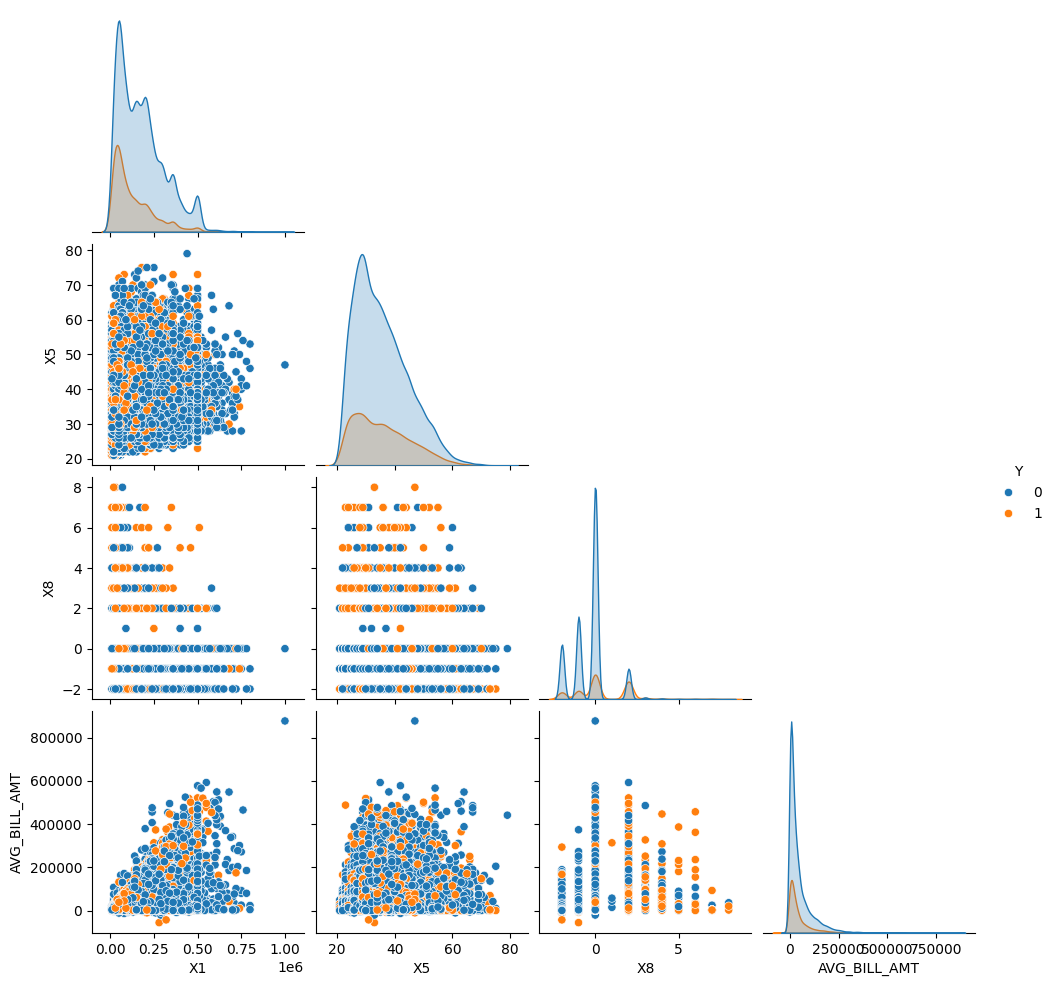

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

pairplot_features = [
    "X1",            # Credit limit
    "X5",            # Age
    "X8",            # Recent repayment status
    "AVG_BILL_AMT",  # Aggregated bill amount
    "Y"              # Target
]

sns.pairplot(
    df_reduced[pairplot_features],
    hue="Y",
    diag_kind="kde",
    corner=True
)

plt.show()


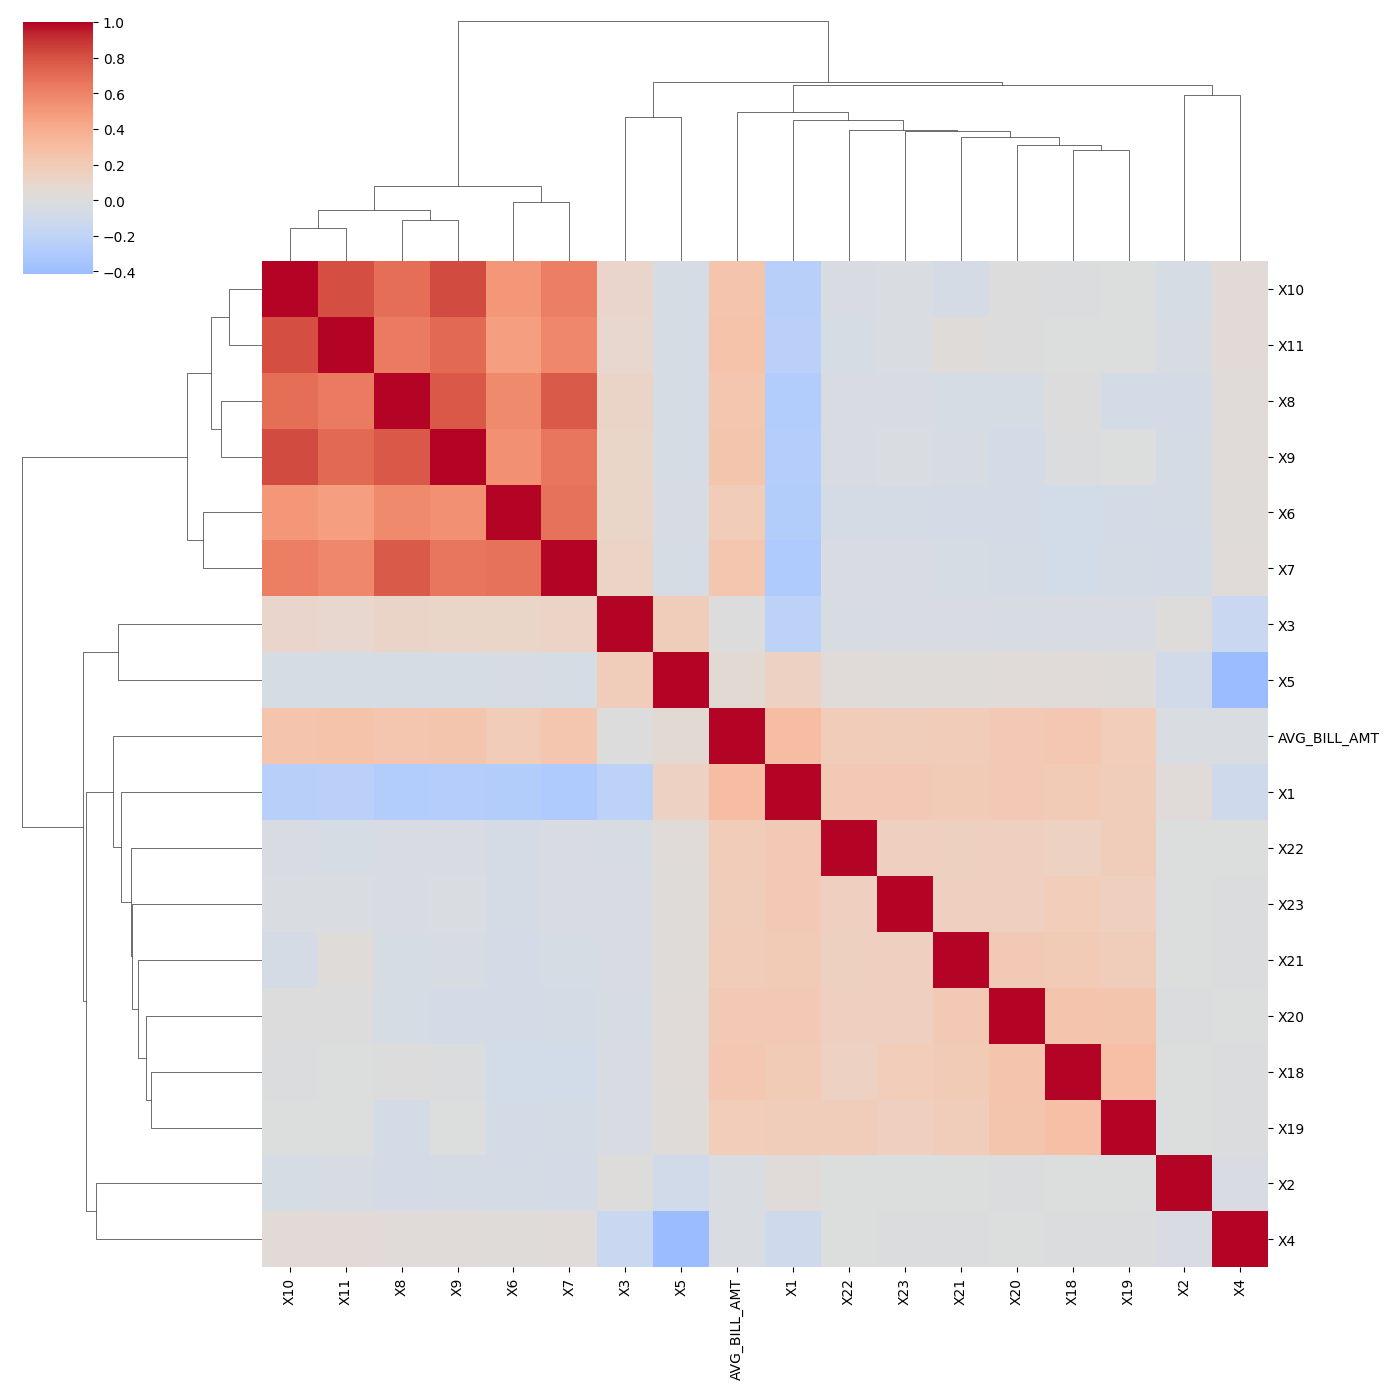

In [40]:
# Compute correlation matrix
corr_matrix = df_reduced.drop(columns=["Y"]).corr()

# Clustered heatmap
sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    figsize=(14, 14)
)

plt.show()


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features / target
X_all = df_reduced.drop(columns=["Y"]).copy()
y_all = df_reduced["Y"].astype(int).values.reshape(-1, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Standardize
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Add intercept column of 1s
X_train_s = np.hstack([np.ones((X_train_s.shape[0], 1)), X_train_s])
X_test_s  = np.hstack([np.ones((X_test_s.shape[0], 1)),  X_test_s])


In [42]:
class LogisticRegression:
    def __init__(self, lr=0.1, n_iters=1000, reg_lambda=0.0, method="batch",
                 batch_size=64, shuffle=True, random_state=42):
        """
        method: 'batch' | 'sgd' | 'minibatch'
        """
        self.lr = lr
        self.n_iters = n_iters
        self.reg_lambda = reg_lambda
        self.method = method
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.w = None
        self.loss_history = []

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        n = X.shape[0]
        p = self._sigmoid(X @ self.w)

        eps = 1e-12
        p = np.clip(p, eps, 1 - eps)

        nll = -(y.T @ np.log(p) + (1 - y).T @ np.log(1 - p)) / n
        nll = nll.item()

        if self.reg_lambda > 0:
            nll += (self.reg_lambda / (2 * n)) * np.sum(self.w[1:] ** 2)

        return nll


    def _gradient(self, X, y):
        """
        Vectorized gradient of NLL + L2 penalty (excluding bias).
        """
        n = X.shape[0]
        p = self._sigmoid(X @ self.w)
        grad = (X.T @ (p - y)) / n

        if self.reg_lambda > 0:
            reg = (self.reg_lambda / n) * self.w
            reg[0] = 0.0
            grad = grad + reg
        return grad

    def fit(self, X, y, log_every=50):
        np.random.seed(self.random_state)
        n, d = X.shape
        self.w = np.zeros((d, 1))
        self.loss_history = []

        if self.method == "batch":
            for t in range(1, self.n_iters + 1):
                grad = self._gradient(X, y)
                self.w -= self.lr * grad

                if t % log_every == 0 or t == 1:
                    self.loss_history.append(self._loss(X, y))

        elif self.method in ["sgd", "minibatch"]:
            idx = np.arange(n)
            bs = 1 if self.method == "sgd" else int(self.batch_size)

            for epoch in range(1, self.n_iters + 1):
                if self.shuffle:
                    np.random.shuffle(idx)

                for start in range(0, n, bs):
                    batch_idx = idx[start:start+bs]
                    Xb, yb = X[batch_idx], y[batch_idx]
                    grad = self._gradient(Xb, yb)
                    self.w -= self.lr * grad

                if epoch % log_every == 0 or epoch == 1:
                    self.loss_history.append(self._loss(X, y))

        else:
            raise ValueError("method must be 'batch', 'sgd', or 'minibatch'")

        return self

    def predict_proba(self, X):
        return self._sigmoid(X @ self.w)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(model, X_te, y_te):
    probs = model.predict_proba(X_te)
    preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds),
        "recall": recall_score(y_te, preds),
        "f1": f1_score(y_te, preds),
        "auc": roc_auc_score(y_te, probs),
    }

# MLE (no regularization); set reg_lambda>0 for MAP/L2
batch = LogisticRegression(lr=0.1, n_iters=800, reg_lambda=0.0, method="batch")
sgd   = LogisticRegression(lr=0.01, n_iters=40, reg_lambda=0.0, method="sgd")        # epochs
mbgd  = LogisticRegression(lr=0.05, n_iters=80, reg_lambda=0.0, method="minibatch", batch_size=256)

batch.fit(X_train_s, y_train, log_every=20)
sgd.fit(X_train_s, y_train, log_every=5)
mbgd.fit(X_train_s, y_train, log_every=10)


               accuracy  precision  recall      f1     auc
Batch GD         0.8075     0.6878  0.2374  0.3529  0.7058
SGD              0.8077     0.6570  0.2728  0.3855  0.6892
Mini-batch GD    0.8068     0.6826  0.2366  0.3514  0.7058


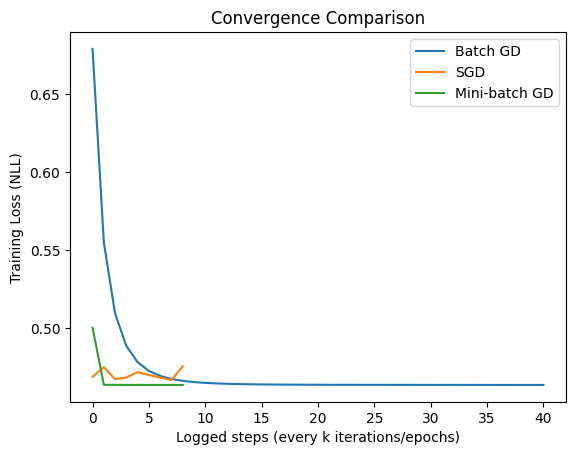

In [44]:

results = pd.DataFrame({
    "Batch GD": evaluate(batch, X_test_s, y_test),
    "SGD": evaluate(sgd, X_test_s, y_test),
    "Mini-batch GD": evaluate(mbgd, X_test_s, y_test),
}).T

# Reorder columns + round
results = results[["accuracy", "precision", "recall", "f1", "auc"]].round(4)

print(results)




# Plot loss curves
plt.figure()
plt.plot(batch.loss_history, label="Batch GD")
plt.plot(sgd.loss_history, label="SGD")
plt.plot(mbgd.loss_history, label="Mini-batch GD")
plt.xlabel("Logged steps (every k iterations/epochs)")
plt.ylabel("Training Loss (NLL)")
plt.legend()
plt.title("Convergence Comparison")
plt.show()

### Gradient Descent Variants

We compared three optimization strategies:

1. **Batch Gradient Descent**  
   Batch GD computes the gradient using the entire training dataset at each iteration. As shown in the convergence plot, Batch GD exhibits a smooth and stable decrease in training loss and converges reliably to a minimum. However, each update is computationally expensive, making it less scalable to large datasets.

2. **Stochastic Gradient Descent**  
   SGD updates parameters using one data point at a time. The convergence curve shows noticeable noise due to high variance in gradient estimates. Despite this, SGD reaches a reasonable solution quickly and can escape shallow local minima, though it may oscillate near the optimum.

3. **Mini-batch Gradient Descent**  
   Mini-batch GD strikes a balance between Batch GD and SGD by using small batches of data. Its convergence curve is smoother than SGD and faster than Batch GD. In practice, it provides a good trade-off between convergence stability and computational efficiency.

---

### Convergence Comparison
The convergence plot demonstrates:
- Batch GD converges smoothly but more slowly.
- SGD converges faster initially but with high variance.
- Mini-batch GD achieves stable and efficient convergence.

These behaviors align with theoretical expectations discussed in class and in the literature on stochastic optimization.

---

### Performance Comparison
All three methods achieve similar accuracy and ROC-AUC scores on the test set. Minor differences in precision and recall are attributable to the stochasticity of SGD-based methods and the imbalanced nature of the dataset. Overall, Mini-batch GD provides the best balance between convergence speed and stability for this task.
